### SENTIMENT ANALYSIS (IN ARABIC) ###

#### TODO ####
  - Try with a CNN, per: https://arxiv.org/pdf/1702.01923.pdf
  - Remove high sequence # outliers (Twitter dataset) (from 176 to closer to 20/30)
  - Arabic Stop Words (https://github.com/mohataher/arabic-stop-words)
    - https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings/code (https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text)
  - GRU vs. LSTM (https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)
  - t-SNE implementation (even though it won't make much sense to non-Arabic reader)
  - Grid Search, across Hyperparams

In [1]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

Using TensorFlow backend.


__[fastText](https://fasttext.cc/)__:
 - 2016, Mikolov [1] (same person who created word2vec)
 - Learning is "fast"
 - Pre-trained word vectors via Facebook Research (https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)
  - Pre-trained word vectors for 294 languages, trained on Wikipedia using fastText. These vectors in dimension 300 were obtained using the skip-gram model described in __[Bojanowski et al. (2016)](https://arxiv.org/abs/1607.04606)__ with default parameters.
 
 
 1. P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov, __[Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606)__
 
__[GloVe](http://nlp.stanford.edu/projects/glove/)__:
 - 2014, Stanford NLP
 
__[word2vec](https://code.google.com/archive/p/word2vec/)__:
 - 2013, Mikolov

__[How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec)__: TL;DR
 - Perform roughtly the same function, but are built differently (Word2Vec is a "predictive" Feed-Fwd NN w/ SGD)
 - GloVe is result of Stanford NLP wanting to build on the Word2Vec concept of "semantic analogies" and yet retain "intrinsic statistical properties of the corpus" (i.e., "word occurrence statistics")

__[GloVe vs word2vec revisited.](http://dsnotes.com/post/glove-enwiki/)__: TL;DR
 - Results are similar enough (maybe GloVe is slightly more accurate)
 - Trade-off: GloVe uses A LOT of RAM/Memory (on order of 15x more!); Word2Vec is 2x slower

#### Credits ####

 - Sentiment Analysis for Arabic Text (tweets, reviews, and standard Arabic) using word2vec
  - https://github.com/iamaziz/ar-embeddings
  - A. Altowayan and L. Tao "Word Embeddings for Arabic Sentiment Analysis", IEEE BigData 2016 Workshop
 - Twitter Data set for Arabic Sentiment Analysis Data Set
  - https://archive.ics.uci.edu/ml/datasets/Twitter+Data+set+for+Arabic+Sentiment+Analysis
  - Abdulla N. A., Mahyoub N. A., Shehab M., Al-Ayyoub M.,Arabic Sentiment Analysis: Corpus-based and Lexicon-based,IEEE conference on Applied Electrical Engineering and Computing Technologies (AEECT 2013),December 3-12, 2013, Amman, Jordan. (Accepted for Publication).

In [2]:
from gensim.models import KeyedVectors
def load_w2v(filepath,binary):
    return KeyedVectors.load_word2vec_format(filepath, binary=binary)

In [3]:
# word2vec (via Aziz Alto), : https://drive.google.com/open?id=0ByiDbCx0i9pEQV9ZUEFIb0hwMmM
# 185 MB; vocab=159175; takes ~5-10 secs to load
#w2v = load_w2v("/home/zmccoy/sandbox/sentiment-analysis-arabic/arabic-news.bin", binary=True)
# --
# fastText (via Facebook Research), Wikipedia: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ar.vec
# 1.5 GB; vocab=610977; takes ~3 mins to load
w2v = load_w2v("/home/zmccoy/sandbox/sentiment-analysis-arabic/wiki.ar.vec", binary=False)
print(len(w2v.vocab))

610977


In [5]:
MAX_SEQUENCE_LENGTH = 85 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
MAX_NB_WORDS = len(w2v.vocab)
EMBEDDING_DIM = 300 # w2v, fastText; GloVe=50

In [6]:
sample = w2v["حسن"]
print(sample.shape)
#print(sample)
print(w2v.most_similar("حسن"))

(300,)
[('،حسن', 0.6795670986175537), ('أبوحسن', 0.6792263388633728), ('#حسن', 0.6771581172943115), ('وحسن', 0.6517007350921631), ('لحسن', 0.6505534648895264), ('\u200fحسن', 0.6446623206138611), ('كحسن', 0.6202388405799866), ('عبدالحسن', 0.6161733865737915), ('بوحسن', 0.6157495379447937), ('د/حسن', 0.6062546968460083)]


In [34]:
import os
import glob
import codecs
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def get_label(path):
    filename = path[path.rfind('/'):]
    if filename.startswith("/pos"):
        return np.array([1, 0])
    return np.array([0, 1])

def get_text(path):
    text = ""
    # use codecs.open to ingnore non utf-8 encoded chars; instead of "with open(path, 'r') as myfile:"
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as myfile:
        text = myfile.read()
    return text

def get_text_sequences(texts):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    #print('Found %s unique tokens.' % len(word_index))
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return data, word_index

def get_data_encoded(path):
    vectors = []
    padded_vectors = []
    unknown_words = []
    labels = []
    all_paths = glob.glob(os.path.join(path,'*.txt'))
    np.random.shuffle(all_paths)
    for path in all_paths:
        # use codecs.open to ingnore non utf-8 encoded chars; instead of "with open(path, 'r') as myfile:"
        with codecs.open(path, "r", encoding='utf-8', errors='ignore') as myfile:
            text = myfile.read()
            word_sequences = text_to_word_sequence(text,
                                        filters='ا\n\ufeff\xa0!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t',
                                        #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                        lower=True,
                                        split=" ")
            vector = []
            for word in word_sequences:
                try:
                    vector.append(w2v[word])
                except KeyError:
                    # TODO: incrementally update w2v with OOVs (out-of-vocabularies)
                    #print("' " + str(word) + "' not in vocabulary")
                    unknown_words.append(word)
            vectors.append(vector)
            label = get_label(path)
            labels.append(label)
    padded_vectors = sequence.pad_sequences(vectors, maxlen=MAX_SEQUENCE_LENGTH)
    return np.array(padded_vectors), np.array(labels), unknown_words
    
def get_data(path):
    texts = []
    labels = []
    all_paths = glob.glob(os.path.join(path,'*.txt'))
    np.random.shuffle(all_paths)
    for path in all_paths: 
        texts.append(get_text(path))
        labels.append(get_label(path))
    sequences, word_index = get_text_sequences(texts)
    return sequences, np.array(labels), word_index

In [96]:
X_train, y_train, word_index_train = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
#X_train, y_train, word_index_train = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
print(X_train.shape)
print(y_train.shape)
print(len(word_index_train))
X_valid, y_valid, word_index_valid = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
#X_valid, y_valid, word_index_valid = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
print(X_valid.shape)
print(y_valid.shape)
print(len(word_index_valid))
#X_test, y_test, word_index_test = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
#print(X_test.shape)
#print(y_test.shape)
#print(len(word_index_test))
word_index = {}
for wi in (word_index_train, word_index_valid, word_index_test): word_index.update(wi)
print(len(word_index))

(1800, 85)
(1800, 2)
6666
(200, 85)
(200, 2)
1731
8235


In [85]:
X_train_enc, y_train, unk_train = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
#X_train_enc, y_train, unk_train = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
print(X_train_enc.shape)
print(y_train.shape)
print(len(unk_train))
X_valid_enc, y_valid, unk_valid = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
#X_valid_enc, y_valid, unk_valid = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
print(X_valid_enc.shape)
print(y_valid.shape)
print(len(unk_valid))
#X_test_enc, y_test, unk_test = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/test")
#X_test_enc, y_test, unk_test = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
#print(X_test_enc.shape)
#print(y_test.shape)
#print(len(unk_test))

(1800, 85, 300)
(1800, 2)
3958
(200, 85, 300)
(200, 2)
969


In [97]:
def create_embedding_matrix(word_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))+1
    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, ii in word_index.items():
        if word in w2v.vocab:
            embedding_matrix[ii] = w2v.word_vec(word)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index)
print(embedding_matrix.shape)

(8236, 300)


In [98]:
embedding_layer = w2v.get_keras_embedding(train_embeddings=False)
print(embedding_layer.input_dim)
print(embedding_layer.output_dim)
#embedding_layer.set_weights(embedding_matrix)
#embedding_layer.get_weights()

610977
300


In [99]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
def get_callbacks(weights_filepath):
    checkpoint = ModelCheckpoint(filepath=weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    callbacks = [checkpoint, early_stopping]
    return callbacks

In [107]:
def get_model_pretrained_embedding(trainable=False):
    weights_filename = "weights/keras-lstm-pretrained-embedding.h5"
    if trainable is True:
        weights_filename = "weights/keras-lstm-pretrained-embedding-trainable.h5"
    #embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable)
    embedding_layer = w2v.get_keras_embedding(train_embeddings=trainable)
    return get_model_embedding(embedding_layer), weights_filename
    
def get_model_from_scratch_embedding():
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)
    return get_model_embedding(embedding_layer), "weights/keras-lstm-from-scratch-embedding.h5"
    
def get_model_embedding(embedding_layer):
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
    embeddings = embedding_layer(sentence_indices)   
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    # Returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model  

def get_model_no_embedding():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM)))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return model, "weights/keras-lstm-no-embedding.h5"

def get_model_pretrained_embedding_bidirectional():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
    embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)
    embeddings = embedding_layer(sentence_indices)   
    X = Bidirectional(LSTM(60, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embeddings)
    X = GlobalMaxPool1D()(X)
    X = Dropout(0.1)(X)
    X = Dense(50)(X)
    X = Activation("relu")(X)
    X = Dropout(0.1)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model, "weights/keras-lstm-pretrained-embedding-bidirectional-trainable.h5"

There are 3 approaches:

 1. Learn embedding from scratch - simply add an Embedding layer to your model
 1. Fine tune learned embeddings - this involves setting word2vec / GloVe vectors as your Embedding layer's weights.
 1. Use word word2vec / Glove word vectors as inputs to your model, instead of one-hot encoding.
 
 
 - (Bidirectional) -see: https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge


In [108]:
#1
model_from_scratch, weights_from_scratch = get_model_from_scratch_embedding()
#2A
model_pt_frozen, weights_pt_frozen = get_model_pretrained_embedding()
#2B
model_pt_trainable, weights_pt_trainable = get_model_pretrained_embedding(trainable=True)
#3
model_no_embedding, weights_no_embedding = get_model_no_embedding()
# Bidirectional
model_bidirectional, weights_bidirectional = get_model_pretrained_embedding_bidirectional()
#model.load_weights(weights_filepath)
#model.summary()

In [109]:
model_from_scratch.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_pt_frozen.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_pt_trainable.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_no_embedding.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model_bidirectional.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [105]:
batch_size = 32
epochs = 10
model_from_scratch.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_from_scratch))
model_pt_frozen.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_pt_frozen))
model_pt_trainable.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_pt_trainable)) 
history = model_no_embedding.fit(X_train_enc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_enc, y_valid), callbacks=get_callbacks(weights_no_embedding))
model_bidirectional.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=get_callbacks(weights_bidirectional)) 

Train on 1800 samples, validate on 200 samples
Epoch 1/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.6299 - acc: 0.6501
Epoch 00001: val_loss improved from inf to 0.87202, saving model to weights/keras-lstm-from-scratch-embedding.h5
1800/1800 [==============================] - 28s 16ms/step - loss: 0.6292 - acc: 0.6511 - val_loss: 0.8720 - val_acc: 0.5200
Epoch 2/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.2234 - acc: 0.9157
Epoch 00002: val_loss did not improve
1800/1800 [==============================] - 26s 15ms/step - loss: 0.2237 - acc: 0.9156 - val_loss: 1.1920 - val_acc: 0.4950
Epoch 3/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9905
Epoch 00003: val_loss did not improve
1800/1800 [==============================] - 26s 14ms/step - loss: 0.0455 - acc: 0.9906 - val_loss: 2.0460 - val_acc: 0.5050
Epoch 4/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9989
Epoch 00004: val_

/home/zmccoy/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 183293100 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 1800 samples, validate on 200 samples
Epoch 1/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.6924 - acc: 0.5391
Epoch 00001: val_loss improved from inf to 0.70036, saving model to weights/keras-lstm-pretrained-embedding-trainable.h5
1800/1800 [==============================] - 173s 96ms/step - loss: 0.6920 - acc: 0.5406 - val_loss: 0.7004 - val_acc: 0.5200
Epoch 2/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.5256 - acc: 0.7500
Epoch 00002: val_loss did not improve
1800/1800 [==============================] - 158s 88ms/step - loss: 0.5238 - acc: 0.7511 - val_loss: 0.9960 - val_acc: 0.5200
Epoch 3/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.2118 - acc: 0.9157
Epoch 00003: val_loss did not improve
1800/1800 [==============================] - 138s 77ms/step - loss: 0.2112 - acc: 0.9161 - val_loss: 1.2224 - val_acc: 0.5450
Epoch 4/10
1792/1800 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9777
Epoch 

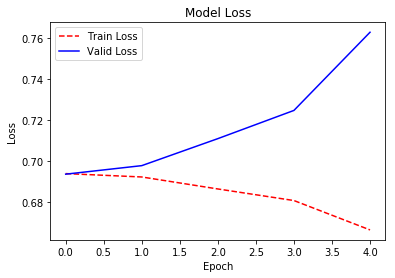

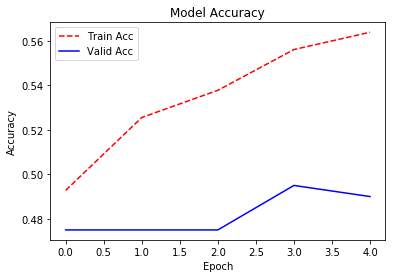

In [106]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [110]:
model_from_scratch.load_weights(weights_from_scratch)
model_pt_frozen.load_weights(weights_pt_frozen)
model_pt_trainable.load_weights(weights_pt_trainable)
model_no_embedding.load_weights(weights_no_embedding)
model_bidirectional.load_weights(weights_bidirectional)

In [111]:
X_data, y_data = X_test, y_test
X_data_enc, y_data = X_test_enc, y_test
print("--- FROM SCRATCH EMBEDDINGS ---")
loss, acc = model_from_scratch.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - FROZEN ---")
loss, acc = model_pt_frozen.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_pt_trainable.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- NO EMBEDDING ---")
loss, acc = model_no_embedding.evaluate(X_data_enc, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_bidirectional.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))

--- FROM SCRATCH EMBEDDINGS ---
52/52 [==============================] - 1s 24ms/step
loss / accuracy = 0.8507 / 0.5192
--- ARABIC EMBEDDINGS - FROZEN ---
52/52 [==============================] - 1s 22ms/step
loss / accuracy = 0.8431 / 0.4423
--- ARABIC EMBEDDINGS - TRAINABLE ---
52/52 [==============================] - 1s 23ms/step
loss / accuracy = 0.6181 / 0.7692
--- NO EMBEDDING ---
52/52 [==============================] - 1s 23ms/step
loss / accuracy = 0.6978 / 0.2308
--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---
52/52 [==============================] - 1s 23ms/step
loss / accuracy = 1.0274 / 0.2692


In [112]:
X_erik_train, y_erik_train, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
X_erik_valid, y_erik_valid, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
X_erik_test, y_erik_test, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
X_erik = np.concatenate((X_erik_train,X_erik_valid,X_erik_test), axis=0)
y_erik = np.concatenate((y_erik_train,y_erik_valid,y_erik_test), axis=0)
print(X_erik.shape)
print(y_erik.shape)

(525, 85)
(525, 2)


In [113]:
X_erik_train_enc, y_erik_train, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/train")
X_erik_valid_enc, y_erik_valid, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/valid")
X_erik_test_enc, y_erik_test, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Erik/test")
X_erik_enc = np.concatenate((X_erik_train_enc,X_erik_valid_enc,X_erik_test_enc), axis=0)
y_erik = np.concatenate((y_erik_train,y_erik_valid,y_erik_test), axis=0)
print(X_erik_enc.shape)
print(y_erik.shape)

(525, 85, 300)
(525, 2)


In [75]:
X_twitter_train, y_twitter_train, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
X_twitter_valid, y_twitter_valid, _ = get_data("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
X_twitter = np.concatenate((X_twitter_train,X_twitter_valid), axis=0)
y_twitter = np.concatenate((y_twitter_train,y_twitter_valid), axis=0)
print(X_twitter.shape)
print(y_twitter.shape)

(2000, 85)
(2000, 2)


In [74]:
X_twitter_train_enc, y_twitter_train, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/train")
X_twitter_valid_enc, y_twitter_valid, _ = get_data_encoded("/home/zmccoy/sandbox/sentiment-analysis-arabic/Twitter/Combined/valid")
X_twitter_enc = np.concatenate((X_twitter_train_enc,X_twitter_valid_enc), axis=0)
y_twitter = np.concatenate((y_twitter_train,y_twitter_valid), axis=0)
print(X_twitter_enc.shape)
print(y_twitter.shape)

(2000, 85, 300)
(2000, 2)


In [114]:
X_data, y_data = X_erik, y_erik
X_data_enc, y_data = X_erik_enc, y_erik
#X_data, y_data = X_twitter, y_twitter
#X_data_enc, y_data = X_twitter_enc, y_twitter

In [115]:
print("--- FROM SCRATCH EMBEDDINGS ---")
loss, acc = model_from_scratch.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - FROZEN ---")
loss, acc = model_pt_frozen.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_pt_trainable.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- NO EMBEDDING ---")
loss, acc = model_no_embedding.evaluate(X_data_enc, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---")
loss, acc = model_bidirectional.evaluate(X_data, y_data, batch_size)
print('loss / accuracy = {:.4f} / {:.4f}'.format(loss, acc))

--- FROM SCRATCH EMBEDDINGS ---
525/525 [==============================] - 2s 4ms/step
loss / accuracy = 0.9327 / 0.5486
--- ARABIC EMBEDDINGS - FROZEN ---
525/525 [==============================] - 2s 3ms/step
loss / accuracy = 0.8423 / 0.4514
--- ARABIC EMBEDDINGS - TRAINABLE ---
525/525 [==============================] - 2s 3ms/step
loss / accuracy = 0.6341 / 0.7086
--- NO EMBEDDING ---
525/525 [==============================] - 2s 3ms/step
loss / accuracy = 0.6972 / 0.2457
--- BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE ---
525/525 [==============================] - 1s 2ms/step
loss / accuracy = 1.0253 / 0.2971


In [132]:
def get_predictions(model, X_data, y_data, display=False):
    preds = np.zeros((0,2))
    labels = np.zeros((0,2))
    for ii in range(len(X_data)):
        prediction = model.predict(np.expand_dims(X_data[ii], axis=0))
        label = y_data[ii]
        preds = np.vstack((preds,prediction))
        labels = np.vstack((labels,label))
        if display is True:
            print(prediction)
            print(label)
    return preds, labels

preds, labels = get_predictions(model_pt_trainable, X_data, y_data, display=True)
#preds, labels = get_predictions(model_no_embedding, X_data_enc, y_data, display=True)

[[ 0.38955691  0.61044306]]
[0 1]
[[ 0.46738824  0.53261179]]
[0 1]
[[ 0.37563965  0.62436038]]
[0 1]
[[ 0.41254196  0.58745813]]
[0 1]
[[ 0.47433105  0.52566898]]
[0 1]
[[ 0.47285086  0.52714908]]
[1 0]
[[ 0.3926962   0.60730374]]
[0 1]
[[ 0.52553743  0.47446257]]
[0 1]
[[ 0.45347041  0.54652965]]
[0 1]
[[ 0.39310077  0.6068992 ]]
[0 1]
[[ 0.40156391  0.59843612]]
[0 1]
[[ 0.54034561  0.45965448]]
[0 1]
[[ 0.51263529  0.48736471]]
[0 1]
[[ 0.52246243  0.47753748]]
[0 1]
[[ 0.35230112  0.64769882]]
[0 1]
[[ 0.39686102  0.60313898]]
[0 1]
[[ 0.43133968  0.56866032]]
[0 1]
[[ 0.60602075  0.39397922]]
[0 1]
[[ 0.45851976  0.54148018]]
[0 1]
[[ 0.39561039  0.60438967]]
[0 1]
[[ 0.50443584  0.4955641 ]]
[0 1]
[[ 0.46357021  0.53642982]]
[0 1]
[[ 0.41842046  0.58157957]]
[0 1]
[[ 0.46045405  0.53954589]]
[0 1]
[[ 0.37818068  0.62181938]]
[0 1]
[[ 0.47843641  0.52156359]]
[0 1]
[[ 0.48342699  0.51657307]]
[0 1]
[[ 0.42096519  0.57903481]]
[0 1]
[[ 0.50423616  0.49576387]]
[0 1]
[[ 0.42047301 

[[ 0.44514439  0.55485564]]
[0 1]
[[ 0.57607871  0.42392132]]
[0 1]
[[ 0.43758893  0.56241113]]
[0 1]
[[ 0.45306426  0.54693574]]
[0 1]
[[ 0.47317347  0.5268265 ]]
[0 1]
[[ 0.43737853  0.56262153]]
[0 1]
[[ 0.41770491  0.58229506]]
[0 1]
[[ 0.44772109  0.55227888]]
[1 0]
[[ 0.47570696  0.52429301]]
[0 1]
[[ 0.36693642  0.63306361]]
[1 0]
[[ 0.41190094  0.588099  ]]
[0 1]
[[ 0.42553145  0.57446861]]
[0 1]
[[ 0.41463265  0.58536732]]
[0 1]
[[ 0.51708961  0.48291045]]
[0 1]
[[ 0.42997116  0.57002884]]
[0 1]
[[ 0.42402837  0.5759716 ]]
[0 1]
[[ 0.40069792  0.59930205]]
[0 1]
[[ 0.38674852  0.61325145]]
[0 1]
[[ 0.41418815  0.58581185]]
[0 1]
[[ 0.41023231  0.58976769]]
[0 1]
[[ 0.59553099  0.40446895]]
[0 1]
[[ 0.44335133  0.55664873]]
[0 1]
[[ 0.48698509  0.51301497]]
[0 1]
[[ 0.41765794  0.58234203]]
[0 1]
[[ 0.39319211  0.60680789]]
[0 1]
[[ 0.40665507  0.59334493]]
[0 1]
[[ 0.48438305  0.51561695]]
[0 1]
[[ 0.37074718  0.62925285]]
[0 1]
[[ 0.48379472  0.51620531]]
[0 1]
[[ 0.45028988 

[[ 0.4918997   0.50810039]]
[0 1]
[[ 0.49644852  0.50355142]]
[0 1]
[[ 0.39086491  0.60913509]]
[0 1]
[[ 0.47528267  0.52471727]]
[0 1]
[[ 0.43410745  0.56589246]]
[0 1]
[[ 0.44339174  0.5566082 ]]
[0 1]
[[ 0.41920286  0.5807972 ]]
[0 1]
[[ 0.55293661  0.44706336]]
[0 1]
[[ 0.39267164  0.6073283 ]]
[1 0]
[[ 0.37579656  0.62420344]]
[0 1]
[[ 0.46122381  0.53877622]]
[0 1]
[[ 0.45454332  0.54545671]]
[0 1]
[[ 0.45474529  0.54525477]]
[0 1]
[[ 0.46725374  0.5327462 ]]
[1 0]
[[ 0.39366403  0.60633594]]
[0 1]
[[ 0.56142032  0.43857962]]
[0 1]
[[ 0.41656473  0.5834353 ]]
[0 1]
[[ 0.45139351  0.5486064 ]]
[0 1]
[[ 0.50813597  0.49186411]]
[0 1]
[[ 0.43235046  0.56764954]]
[0 1]
[[ 0.47683141  0.52316856]]
[0 1]
[[ 0.38178942  0.61821055]]
[0 1]
[[ 0.38316235  0.61683768]]
[0 1]
[[ 0.44230565  0.55769432]]
[0 1]
[[ 0.39584169  0.60415828]]
[0 1]
[[ 0.4939577  0.5060423]]
[0 1]
[[ 0.36556771  0.63443226]]
[0 1]
[[ 0.33606058  0.66393948]]
[0 1]
[[ 0.39068362  0.60931635]]
[0 1]


In [124]:
import itertools
import math
from sklearn.metrics import confusion_matrix

def print_statistics(cm):
    tn, fp, fn, tp = cm.ravel()
    # TP
    print("TP: " + str(tp))
    # TN
    print("TN: " + str(tn))
    # FP
    print("FP: " + str(fp))
    # FN
    print("FN: " + str(fn))
    # TPR
    recall = tp/(tp+fn)
    print("TPR/recall: " + str(recall))
    # TNR
    specificity = tn/(tn+fp)
    print("TNR/specificity: " + str(specificity))
    # PPV
    precision = tp/(tp+fp)
    print("PPV/precision: " + str(precision))
    # NPV
    npv = tn/(tn+fn)
    print("NPV/negative predictive value: " + str(npv))
    # FNR
    miss_rate = 1-recall
    print("FNR/false negative rate: " + str(miss_rate))
    # FPR
    fall_out = 1-specificity
    print("FPR/false positive rate: " + str(fall_out))
    # FDR
    fdr = 1-precision
    print("FDR/false discovery rate: " + str(fdr))
    # FOR
    fomr = 1-npv
    print("FOR/false ommission rate: " + str(fomr))
    # F1
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 score: " + str(f1))
    # accuracy
    acc = (tp+tn)/(tp+tn+fp+fn)
    print("Accuracy: " + str(acc))
    # Matthews correlation coefficient (MCC)
    mcc = (tp*tn-fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print("MCC/Matthews correlation coefficient: " + str(mcc))
    # Informedness or Bookmaker Informedness (BM)
    bm = recall+specificity-1
    print("BM/Bookmaker Informedness: " + str(bm))
    # Markedness (MK)
    mk = precision+npv-1
    print("MK/Markedness: " + str(mk))
    
    return fall_out, recall

# credit: https://github.com/scikit-learn/scikit-learn/blob/master/examples/model_selection/plot_confusion_matrix.py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    s = [['TN','FP'], ['FN', 'TP']]
    #s = [['TP','FN'], ['FP', 'TN']]
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, (str(s[i][j])+" = "+str(format(cm[i][j],fmt))),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TP: 256
TN: 32
FP: 26
FN: 211
TPR/recall: 0.54817987152
TNR/specificity: 0.551724137931
PPV/precision: 0.90780141844
NPV/negative predictive value: 0.131687242798
FNR/false negative rate: 0.45182012848
FPR/false positive rate: 0.448275862069
FDR/false discovery rate: 0.0921985815603
FOR/false ommission rate: 0.868312757202
F1 score: 0.683578104139
Accuracy: 0.548571428571
MCC/Matthews correlation coefficient: 0.0628098366942
BM/Bookmaker Informedness: 0.0999040094514
MK/Markedness: 0.0394886612381


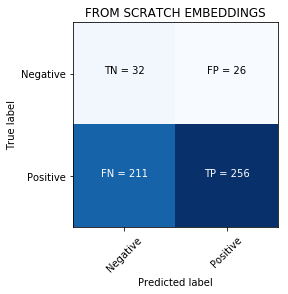

In [127]:
preds, labels = get_predictions(model_from_scratch, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='FROM SCRATCH EMBEDDINGS')
plt.show()

TP: 207
TN: 30
FP: 28
FN: 260
TPR/recall: 0.443254817987
TNR/specificity: 0.51724137931
PPV/precision: 0.88085106383
NPV/negative predictive value: 0.103448275862
FNR/false negative rate: 0.556745182013
FPR/false positive rate: 0.48275862069
FDR/false discovery rate: 0.11914893617
FOR/false ommission rate: 0.896551724138
F1 score: 0.589743589744
Accuracy: 0.451428571429
MCC/Matthews correlation coefficient: -0.0249045334651
BM/Bookmaker Informedness: -0.0395038027025
MK/Markedness: -0.0157006603081


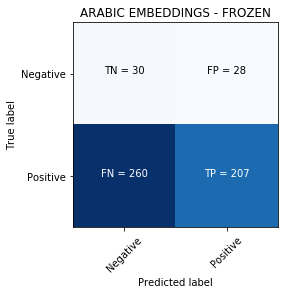

In [128]:
preds, labels = get_predictions(model_pt_frozen, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='ARABIC EMBEDDINGS - FROZEN')
plt.show()

TP: 358
TN: 14
FP: 44
FN: 109
TPR/recall: 0.766595289079
TNR/specificity: 0.241379310345
PPV/precision: 0.890547263682
NPV/negative predictive value: 0.113821138211
FNR/false negative rate: 0.233404710921
FPR/false positive rate: 0.758620689655
FDR/false discovery rate: 0.109452736318
FOR/false ommission rate: 0.886178861789
F1 score: 0.823935558113
Accuracy: 0.708571428571
MCC/Matthews correlation coefficient: 0.00590222459923
BM/Bookmaker Informedness: 0.00797459942406
MK/Markedness: 0.00436840189297


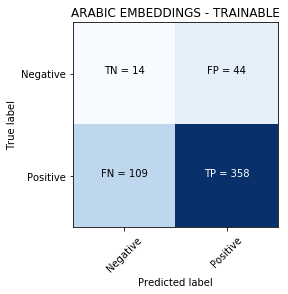

In [129]:
preds, labels = get_predictions(model_pt_trainable, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='ARABIC EMBEDDINGS - TRAINABLE')
plt.show()

TP: 79
TN: 50
FP: 8
FN: 388
TPR/recall: 0.169164882227
TNR/specificity: 0.862068965517
PPV/precision: 0.908045977011
NPV/negative predictive value: 0.114155251142
FNR/false negative rate: 0.830835117773
FPR/false positive rate: 0.137931034483
FDR/false discovery rate: 0.0919540229885
FOR/false ommission rate: 0.885844748858
F1 score: 0.285198555957
Accuracy: 0.245714285714
MCC/Matthews correlation coefficient: 0.0263330548905
BM/Bookmaker Informedness: 0.0312338477442
MK/Markedness: 0.022201228153


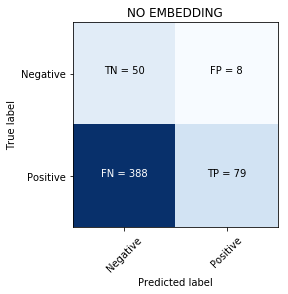

In [130]:
preds, labels = get_predictions(model_no_embedding, X_data_enc, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='NO EMBEDDING')
plt.show()

TP: 113
TN: 43
FP: 15
FN: 354
TPR/recall: 0.241970021413
TNR/specificity: 0.741379310345
PPV/precision: 0.8828125
NPV/negative predictive value: 0.108312342569
FNR/false negative rate: 0.758029978587
FPR/false positive rate: 0.258620689655
FDR/false discovery rate: 0.1171875
FOR/false ommission rate: 0.891687657431
F1 score: 0.379831932773
Accuracy: 0.297142857143
MCC/Matthews correlation coefficient: -0.0121563687824
BM/Bookmaker Informedness: -0.0166506682419
MK/Markedness: -0.00887515743073


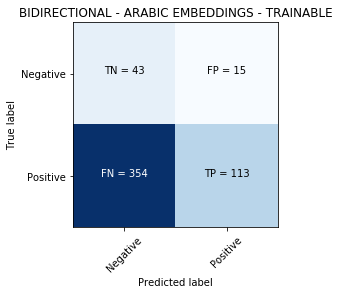

In [131]:
preds, labels = get_predictions(model_bidirectional, X_data, y_data)

y_trues = [np.argmax(ii) for ii in labels]
y_preds = [np.argmax(ii) for ii in preds]

cm = confusion_matrix(y_trues, y_preds)
fpr, tpr = print_statistics(cm)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative','Positive'], title='BIDIRECTIONAL - ARABIC EMBEDDINGS - TRAINABLE')
plt.show()